In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve , average_precision_score, confusion_matrix , accuracy_score , precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import train_test_split , cross_val_score
import warnings
warnings.filterwarnings('ignore')
import joblib


In [16]:
churn_df = pd.read_csv('churn_data.csv')

In [17]:
churn_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [18]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [19]:
churn_df['TotalCharges'] = churn_df['TotalCharges'].replace({' ': 0})
churn_df['TotalCharges'] = churn_df['TotalCharges'].astype(float)

In [20]:
churn_df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


### Feature Engineering

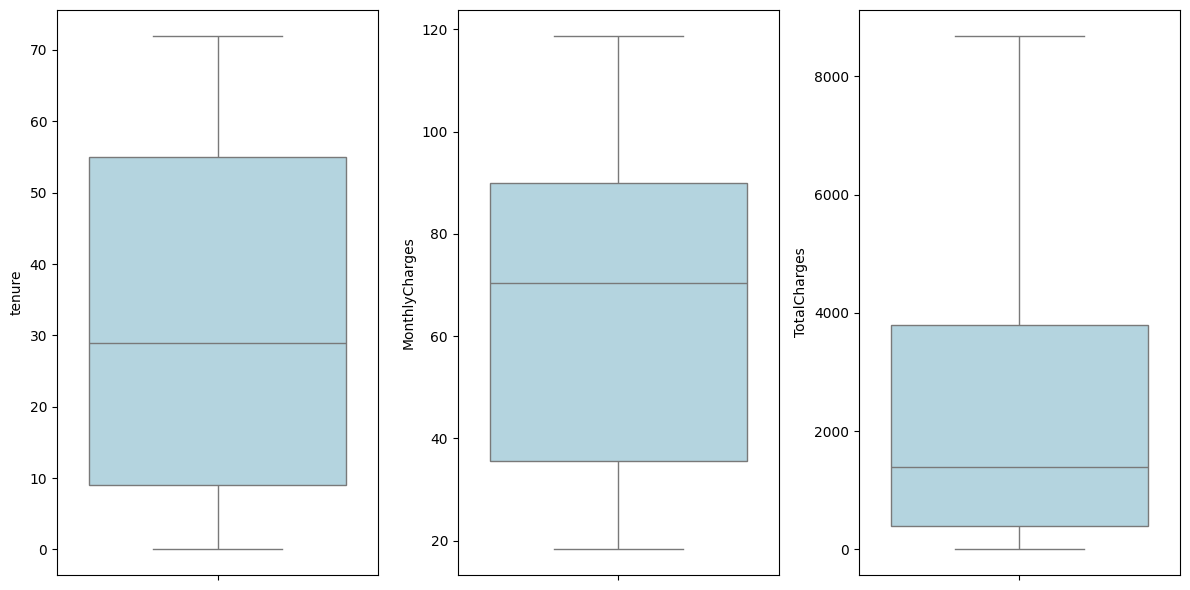

In [21]:
outlier_col = ['tenure' , 'MonthlyCharges' , 'TotalCharges']
Q1 = churn_df[outlier_col].quantile(0.25)
Q3 = churn_df[outlier_col].quantile(0.75)
IQR = Q3 - Q1
outliers = ((churn_df[outlier_col] < (Q1 - 1.5 * IQR)) | (churn_df[outlier_col] > (Q3 + 1.5 * IQR)))

# Plot box plots with outliers marked
plt.figure(figsize=(12, 6))
for i, column in enumerate(outlier_col):
    plt.subplot(1, len(outlier_col), i + 1)
    sns.boxplot(y=churn_df[column], color="lightblue")
    # Mark outliers
    for j, value in enumerate(churn_df[column]):
        if outliers[column].iloc[j]:
            plt.scatter(0, value, color='red', edgecolors='black')

plt.tight_layout()
plt.show()

In [22]:
def describe_more(df,normalize_ind=False, weight_column=None, skip_columns=[], dropna=True):
    var = [] ; l = [] ; t = []; unq =[]; min_l = []; max_l = [];
    assert isinstance(skip_columns, list), "Argument skip_columns should be list"
    if weight_column is not None:
        if weight_column not in list(df.columns):
            raise AssertionError('weight_column is not a valid column name in the input DataFrame')
      
    for x in df:
        if x in skip_columns:
            pass
        else:
            var.append( x )
            uniq_counts = len(pd.value_counts(df[x],dropna=dropna))
            uniq_counts = len(pd.value_counts(df[x], dropna=dropna)[pd.value_counts(df[x],dropna=dropna)>0])
            l.append(uniq_counts)
            t.append( df[ x ].dtypes )
            min_l.append(df[x].apply(str).str.len().min())
            max_l.append(df[x].apply(str).str.len().max())
            if weight_column is not None and x not in skip_columns:
                df2 = df.groupby(x).agg({weight_column: 'sum'}).sort_values(weight_column, ascending=False)
                df2['authtrans_vts_cnt']=((df2[weight_column])/df2[weight_column].sum()).round(2)
                unq.append(df2.head(n=100).to_dict()[weight_column])
            else:
                df_cat_d = df[x].value_counts(normalize=normalize_ind,dropna=dropna).round(decimals=2)
                df_cat_d = df_cat_d[df_cat_d>0]
                #unq.append(df[x].value_counts().iloc[0:100].to_dict())
                unq.append(df_cat_d.iloc[0:100].to_dict())
            
    levels = pd.DataFrame( { 'A_Variable' : var , 'Levels' : l , 'Datatype' : t ,
                             'Min Length' : min_l,
                             'Max Length': max_l,
                             'Level_Values' : unq} )
    #levels.sort_values( by = 'Levels' , inplace = True )
    return levels

In [23]:
describe_more(churn_df)

,A_Variable,Levels,Datatype,Min Length,Max Length,Level_Values
0,customerID,7043,object,10,10,"{'7590-VHVEG': 1, '3791-LGQCY': 1, '6008-NAIXK..."
1,gender,2,object,4,6,"{'Male': 3555, 'Female': 3488}"
2,SeniorCitizen,2,int64,1,1,"{0: 5901, 1: 1142}"
3,Partner,2,object,2,3,"{'No': 3641, 'Yes': 3402}"
4,Dependents,2,object,2,3,"{'No': 4933, 'Yes': 2110}"
5,tenure,73,int64,1,2,"{1: 613, 72: 362, 2: 238, 3: 200, 4: 176, 71: ..."
6,PhoneService,2,object,2,3,"{'Yes': 6361, 'No': 682}"
7,MultipleLines,3,object,2,16,"{'No': 3390, 'Yes': 2971, 'No phone service': ..."
8,InternetService,3,object,2,11,"{'Fiber optic': 3096, 'DSL': 2421, 'No': 1526}"
9,OnlineSecurity,3,object,2,19,"{'No': 3498, 'Yes': 2019, 'No internet service..."


In [38]:
columns_to_encode = ['gender', 'Partner', 'Dependents', 'SeniorCitizen'
                     , 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'Churn']

In [39]:
label_encoder = LabelEncoder()
label_df = pd.DataFrame()
for i in range(0 , len(columns_to_encode)):
    label_df[columns_to_encode[i] + " label"] = label_encoder.fit_transform(churn_df[columns_to_encode[i]])
encode_df = churn_df.drop(columns=['customerID'])
label_encode = pd.concat([encode_df, label_df], axis=1)
label_encode = label_encode.drop(columns_to_encode, axis=1).replace({' ': 0}).astype(float)

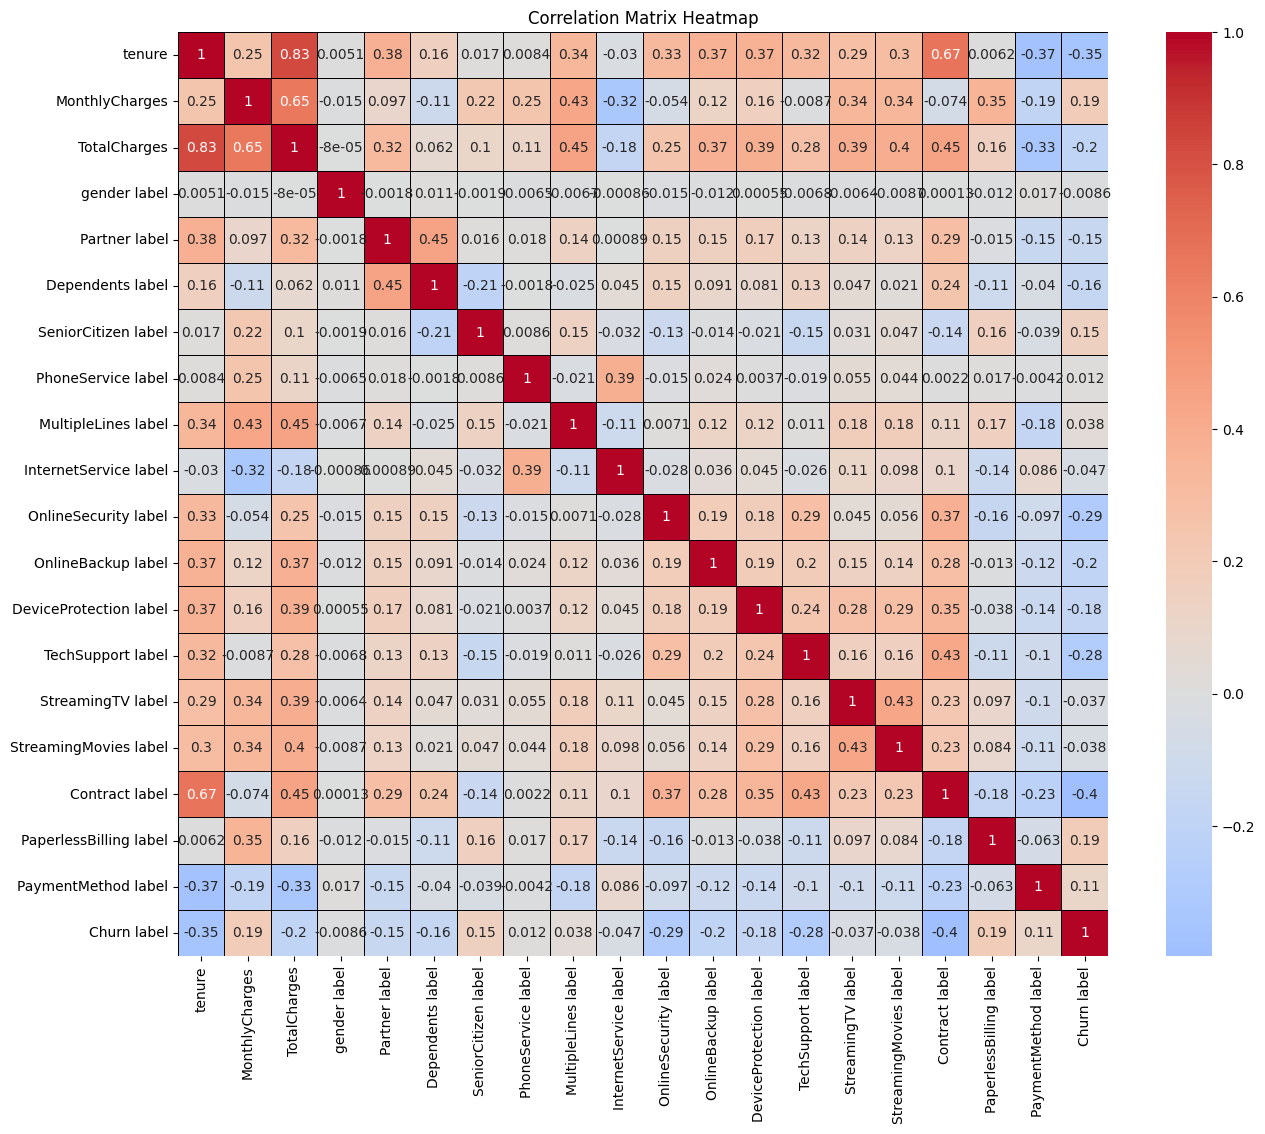

In [40]:
# Compute the correlation matrix
correlation_matrix = label_encode.corr()

# Plot the heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5, linecolor='black')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [41]:

encoder = OneHotEncoder(sparse_output= False)
dummy_df = encoder.fit_transform(encode_df[columns_to_encode])
one_hot_df = pd.DataFrame(dummy_df, columns=encoder.get_feature_names_out(columns_to_encode))
df_encoded = pd.concat([encode_df, one_hot_df], axis=1)
df_encoded = df_encoded.drop(columns_to_encode, axis=1).replace({' ': 0}).astype(float)
x = df_encoded.drop(columns= ['Churn_No', 'Churn_Yes'])
y = df_encoded['Churn_Yes']
# dummi_df  = dummi_df 

In [43]:
df_encoded .columns

Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'gender_Female',
       'gender_Male', 'Partner_No', 'Partner_Yes', 'Dependents_No',
       'Dependents_Yes', 'SeniorCitizen_0', 'SeniorCitizen_1',
       'PhoneService_No', 'PhoneService_Yes', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       '

In [45]:
joblib.dump(encoder, 'customer_encoder.pkl')

['customer_encoder.pkl']

### Random Forest Classifier

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
rf_p_list = {'n_estimators' : [10 , 30 , 100 , 400 , 1000],
            'max_depth' : [3 , 5 , 10 , None],
             'max_features' : randint(1,3),
             'criterion' : ['gini' , 'entropy'],
             'min_samples_leaf' : randint(1,4),
             }

In [24]:
est = RandomForestClassifier()
rmdsearch = RandomizedSearchCV(est , param_distributions= rf_p_list , n_iter= 40,
                               n_jobs= -1 , cv = 10)
rmdsearch.fit(x , y)
rmdsearch.best_params_

NameError: name 'x' is not defined

In [49]:
from sklearn.model_selection import cross_val_score
est = RandomForestClassifier(criterion='entropy', max_depth=10, max_features=2,
                             min_samples_leaf=3 , n_estimators=100)
est.fit(x,y)
score = cross_val_score(est, x, y , cv= 5)
print(score)
print(score.mean())

[0.79772889 0.79772889 0.78424414 0.79048295 0.80326705]
0.7946903832505323


0.8204400283889283
[[943  86]
 [167 213]]


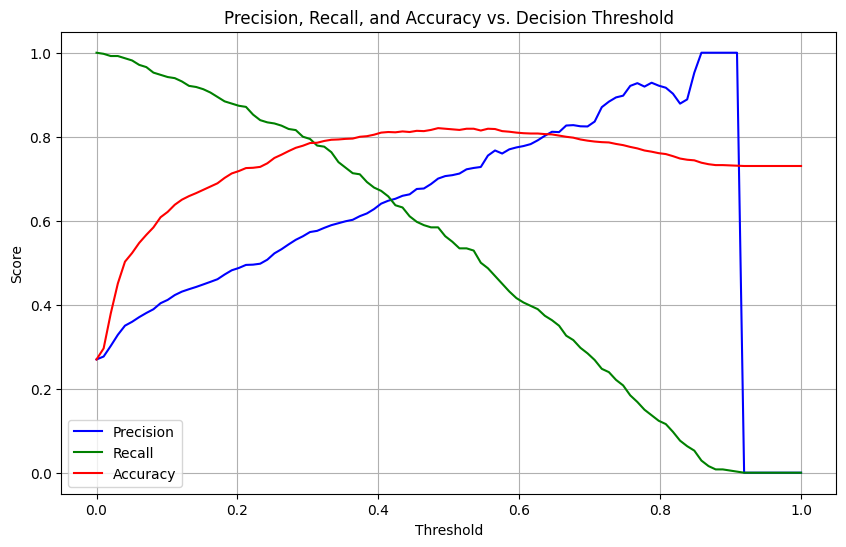

In [69]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=140)
pred = est.predict(x_test)
print(accuracy_score(y_test, pred))
print(confusion_matrix(y_test, pred))

y_probs = est.predict_proba(x_test)[:, 1]

thresholds = np.linspace(0, 1, 100)
precisions = []
recalls = []
accuracies = []


# Calculate precision, recall, and accuracy for each threshold
for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    accuracies.append(accuracy_score(y_test, y_pred))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='green')
plt.plot(thresholds, accuracies, label='Accuracy', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and Accuracy vs. Decision Threshold')
plt.legend(loc='best')
plt.grid(True)
plt.show()

Hence we can conclude thresold to be 0.3 for best accuracy and recall

### XGBoost Classifier

In [39]:
import xgboost
from sklearn.model_selection import cross_val_score

In [40]:
xgb_p_list = {'n_estimators' : [10 , 30 , 100 , 400 , 1000],
            'max_depth' : [3 , 5 , 10 , None],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'min_child_weight': [1, 3, 6, 10],
            'subsample': [0.5,0.6, 0.85, 1.0],
            'colsample_bytree': [0.3 ,0.5, 0.75, 1.0],
            'gamma': [0, 0.1, 0.2 , 0.5],
            'reg_alpha': [0, 0.1, 0.5],
            'reg_lambda': [0.5, 1.0, 1.5]
             }

In [43]:
est = xgboost.XGBClassifier()
xgbsearch = RandomizedSearchCV(est , param_distributions= xgb_p_list , n_iter= 40,
                               n_jobs= -1 , cv = 10 )
xgbsearch.fit(x , y)
print(xgbsearch.best_params_)

{'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 6, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.5}


In [44]:
est = xgboost.XGBClassifier(n_estimators = 100, max_depth = 3, learning_rate = 0.1,
            min_child_weight = 6 , subsample= 0.6,
            colsample_bytree = 0.5, gamma =0.1, reg_alpha = 0,
            reg_lambda = 0.5)

est.fit(x,y)
score = cross_val_score(est, x, y , cv= 10)
print(score)
print(score.mean())

[0.81276596 0.81134752 0.79858156 0.81107955 0.79971591 0.78835227
 0.82102273 0.796875   0.79545455 0.81676136]
0.8051956399097356


0.8261178140525195
[[951  77]
 [168 213]]


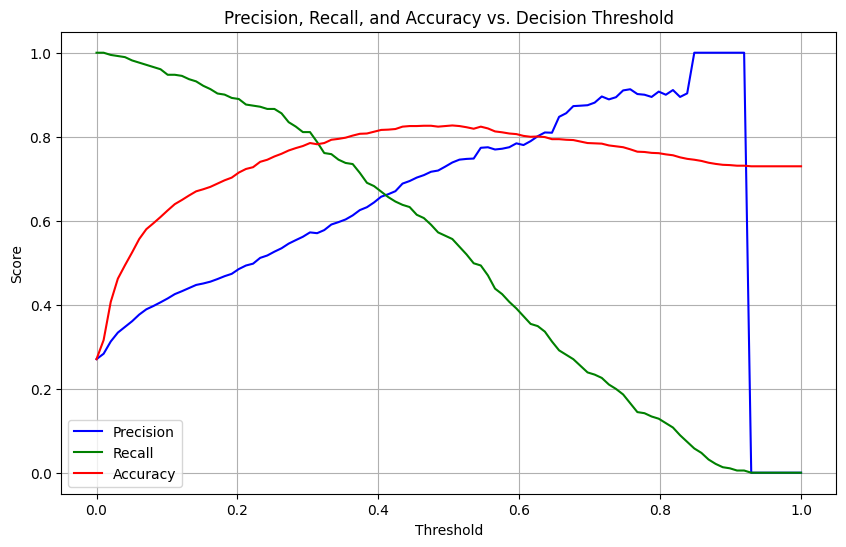

In [45]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)
pred = est.predict(x_test)
print(accuracy_score(y_test, pred))
print(confusion_matrix(y_test, pred))

y_probs = est.predict_proba(x_test)[:, 1]

thresholds = np.linspace(0, 1, 100)
precisions = []
recalls = []
accuracies = []


# Calculate precision, recall, and accuracy for each threshold
for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    accuracies.append(accuracy_score(y_test, y_pred))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='green')
plt.plot(thresholds, accuracies, label='Accuracy', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and Accuracy vs. Decision Threshold')
plt.legend(loc='best')
plt.grid(True)
plt.show()

Thresold = 0.3 for best accuracy and recall

In [46]:
est.save_model('churn_predict_model.json')

### Gradiant descent Tree Classifier

In [79]:
from sklearn.ensemble import GradientBoostingClassifier

In [80]:
gb_p_list = {'n_estimators' : [10 , 30 , 100 , 400 , 1000],
            'max_depth' : [3 , 5 , 10 , None],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'min_samples_split': [2 , 4 , 8 , 12 , 20],
            'min_samples_leaf': [1 , 2 , 4 , 8 , 12 , 20],
            'subsample': [0.5,0.6, 0.85, 1.0]
             }

In [81]:
est = GradientBoostingClassifier()
gbsearch = RandomizedSearchCV(est , param_distributions= gb_p_list , n_iter= 40,
                               n_jobs= -1 , cv = 10)
gbsearch.fit(x , y)

gbsearch.best_params_


{'subsample': 0.6,
 'n_estimators': 30,
 'min_samples_split': 12,
 'min_samples_leaf': 4,
 'max_depth': 3,
 'learning_rate': 0.1}

In [82]:
est = GradientBoostingClassifier(n_estimators = 30, max_depth = 3 ,
                                  learning_rate = 0.1 , min_samples_split = 12 ,
                                  min_samples_leaf= 4 , subsample= 0.6)

est.fit(x,y)
score = cross_val_score(est, x, y , cv= 10 )
print(score)
print(score.mean())

[0.80851064 0.80425532 0.79858156 0.81676136 0.77840909 0.78693182
 0.81818182 0.79545455 0.78977273 0.81534091]
0.8012199790457769


0.8225691980127751
[[941  77]
 [173 218]]


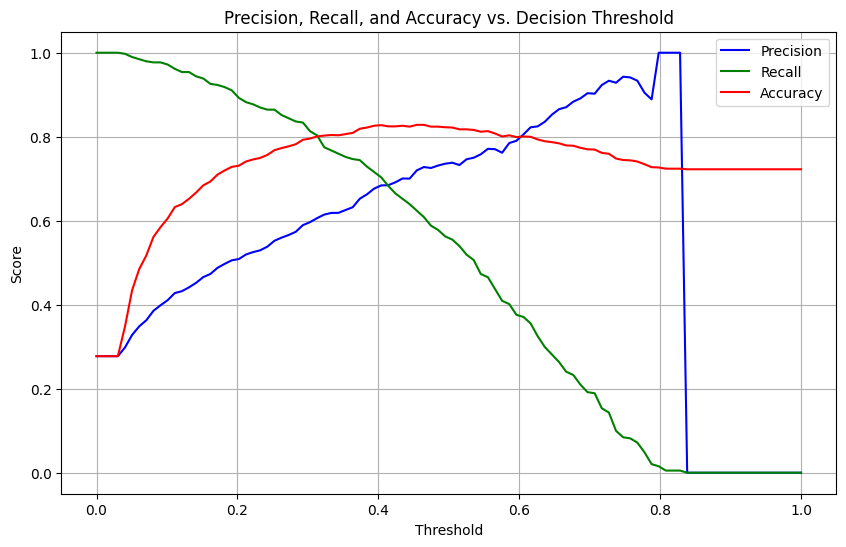

In [84]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)
pred = est.predict(x_test)
print(accuracy_score(y_test, pred))
print(confusion_matrix(y_test, pred))

thresholds = np.linspace(0, 1, 100)
precisions = []
recalls = []
accuracies = []

y_probs = est.predict_proba(x_test)[:, 1]

# Calculate precision, recall, and accuracy for each threshold
for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    accuracies.append(accuracy_score(y_test, y_pred))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='green')
plt.plot(thresholds, accuracies, label='Accuracy', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and Accuracy vs. Decision Threshold')
plt.legend(loc='best')
plt.grid(True)
plt.show()

Thresold = 0.3 for best accuracy and recall

### KNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn_p_list = {'n_neighbors' : [1 , 2 , 3 , 5 , 8 , 10 , 15 , 20],
            'weights' : ['uniform' , 'distance'],
            'leaf_size': [20 , 22 , 25 , 30 ,40]
             }

In [ ]:
est = KNeighborsClassifier()
knnsearch = RandomizedSearchCV(est , param_distributions= knn_p_list , n_iter= 40,
                               n_jobs= -1 , cv = 10)
knnsearch.fit(x , y)
print(knnsearch.best_params_)

{'weights': 'uniform', 'n_neighbors': 10, 'leaf_size': 30}


In [ ]:
est = KNeighborsClassifier(n_neighbors = 10 , leaf_size= 30 ,
                            weights= 'uniform')

est.fit(x,y)
score = cross_val_score(est, x, y , cv= 10)
print(score)
print(score.mean())

[0.77021277 0.78865248 0.7787234  0.78693182 0.78693182 0.77556818
 0.80397727 0.77414773 0.78409091 0.79829545]
0.7847531834300451


In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)
pred = est.predict(x_test)
print(accuracy_score(y_test, pred))
print(confusion_matrix(y_test, pred))

0.830376153300213
[[997  53]
 [186 173]]
